In [29]:
"""Imports & Project Setup"""

import sys
import os
import matplotlib.pyplot as plt
from pyspark.sql.functions import (
    col, sin, cos, dayofweek, when, avg, hour
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.regression import (
    DecisionTreeRegressor,
    RandomForestRegressor,
    GBTRegressor
)
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

sys.path.append(os.path.abspath('..'))
from utils import get_spark_session, PATHS

spark = get_spark_session("LargeST-ML")

In [2]:
"""Load Pre-processed Data"""

print(f"Loading data from: {PATHS['clean_enriched']}")
clean_df = spark.read.parquet(PATHS['clean_enriched'])

Loading data from: hdfs:///user/ubuntu/largest_parquet_clean_enriched/clean_enriched


In [3]:
"""Feature Engineering: Cyclic Time & Rush Hour"""

clean_df = clean_df.withColumn("hour", hour(col("timestamp")))

clean_df = clean_df.withColumn(
    "hour_sin", sin(2 * 3.141592653589793 * col("hour") / 24)
).withColumn(
    "hour_cos", cos(2 * 3.141592653589793 * col("hour") / 24)
)

clean_df = clean_df.withColumn(
    "is_weekend",
    dayofweek(col("timestamp")).isin([1, 7]).cast("int")
)

clean_df = clean_df.withColumn(
    "is_rush",
    when(col("hour").isin([7, 8, 9, 16, 17, 18]), 1).otherwise(0)
)

In [4]:
"""Data Aggregation for ML"""

ml_df = (
    clean_df
    .groupBy(
        "sensor_id",
        "hour",
        "hour_sin",
        "hour_cos",
        "is_weekend",
        "is_rush",
        "Lanes",
        "Direction",
        "County"
    )
    .agg(
        avg("value").alias("mean_traffic")
    )
    .dropna()
    .cache()
)

print(f"Total samples for ML: {ml_df.count()}")

[Stage 3:==================================>                       (6 + 4) / 10]

Total samples for ML: 412800


In [5]:
"""Feature Pipeline: Indexing & Encoding"""

direction_indexer = StringIndexer(
    inputCol="Direction",
    outputCol="Direction_idx",
    handleInvalid="keep"
)

county_indexer = StringIndexer(
    inputCol="County",
    outputCol="County_idx",
    handleInvalid="keep"
)

encoder = OneHotEncoder(
    inputCols=["Direction_idx", "County_idx"],
    outputCols=["Direction_ohe", "County_ohe"]
)

In [6]:
"""Feature Pipeline: Vector Assembly"""

feature_columns = [
    "hour_sin",
    "hour_cos",
    "is_weekend",
    "is_rush",
    "Lanes",
    "Direction_ohe",
    "County_ohe"
]

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

In [7]:
"""Apply Pipeline & Cache Data"""

feature_pipeline = Pipeline(stages=[
    direction_indexer,
    county_indexer,
    encoder,
    assembler
])

ml_ready_df = feature_pipeline.fit(ml_df).transform(ml_df).cache()
ml_ready_df.select("features", "mean_traffic").show(5, truncate=False)

+----------------------------------------------------------------------------+------------------+
|features                                                                    |mean_traffic      |
+----------------------------------------------------------------------------+------------------+
|(43,[1,2,4,5,10],[1.0,1.0,6.0,1.0,1.0])                                     |152.41538707613563|
|(43,[0,1,2,4,5,10],[0.25881904510252074,0.9659258262890683,1.0,4.0,1.0,1.0])|128.98016634676904|
|(43,[0,1,2,4,7,11],[0.49999999999999994,0.8660254037844387,1.0,3.0,1.0,1.0])|25.16359819121447 |
|(43,[0,1,2,4,5,10],[0.49999999999999994,0.8660254037844387,1.0,5.0,1.0,1.0])|74.61692506459949 |
|(43,[0,1,2,4,6,11],[0.8660254037844386,0.5000000000000001,1.0,5.0,1.0,1.0]) |33.99216250799744 |
+----------------------------------------------------------------------------+------------------+
only showing top 5 rows



In [8]:
"""Train/Test Split"""

train_df, test_df = ml_ready_df.randomSplit([0.8, 0.2], seed=42)
print(f"Training set: {train_df.count()}, Test set: {test_df.count()}")

Training set: 330552, Test set: 82248


In [9]:
"""Linear Regression: Model Training"""

lr = LinearRegression(
    featuresCol="features",
    labelCol="mean_traffic"
)

lr_model = lr.fit(train_df)
print("Linear Regression model trained.")

26/01/14 17:10:56 WARN Instrumentation: [36d83559] regParam is zero, which might cause numerical instability and overfitting.
26/01/14 17:10:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/01/14 17:10:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
[Stage 37:============================>                            (5 + 5) / 10]

Linear Regression model trained.


In [10]:
"""Linear Regression: Evaluation (RMSE)"""

predictions = lr_model.transform(test_df)

rmse = RegressionEvaluator(
    labelCol="mean_traffic",
    predictionCol="prediction",
    metricName="rmse"
).evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 87.3753


In [11]:
"""Linear Regression: Feature Importance Extraction"""

base_feature_names = [
    "hour_sin", "hour_cos", "is_weekend", "is_rush", "Lanes"
]

coefficients = lr_model.coefficients.toArray()[:len(base_feature_names)]

feature_importance_df = spark.createDataFrame(
    zip(base_feature_names, map(float, coefficients)),
    ["feature", "coefficient"]
).orderBy("coefficient", ascending=False)

feature_importance_df.show()

[Stage 42:>                                                         (0 + 6) / 6]

+----------+-------------------+
|   feature|        coefficient|
+----------+-------------------+
|     Lanes|  68.26990412534575|
|   is_rush|  31.38611086560462|
|is_weekend|-24.999604988977204|
|  hour_sin|  -58.4577204397268|
|  hour_cos|-119.82322572818697|
+----------+-------------------+



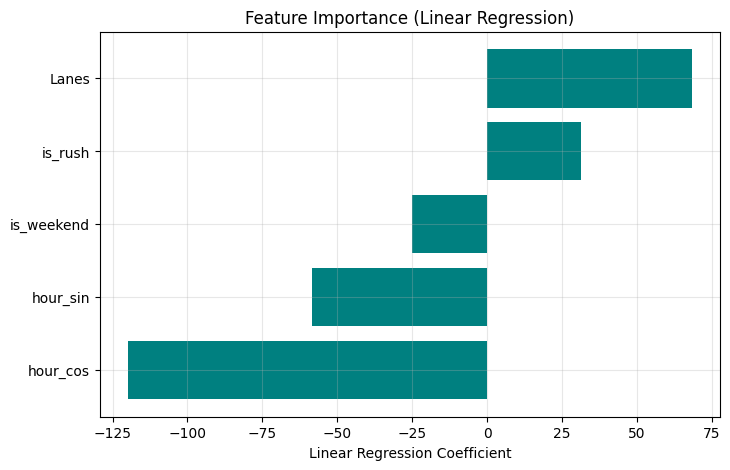

In [12]:
"""Linear Regression: Feature Importance Visualization"""

fi_pd = feature_importance_df.toPandas()

plt.figure(figsize=(8, 5))
plt.barh(fi_pd["feature"], fi_pd["coefficient"], color='teal')
plt.xlabel("Linear Regression Coefficient")
plt.title("Feature Importance (Linear Regression)")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()

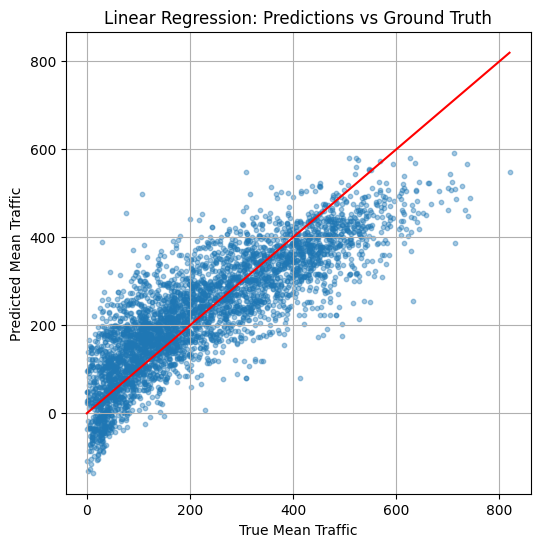

In [13]:
lr_pd = (
    lr_model
    .transform(test_df)
    .select("mean_traffic", "prediction")
    .sample(fraction=0.05, seed=42)
    .toPandas()
)

plt.figure(figsize=(6, 6))
plt.scatter(lr_pd["mean_traffic"], lr_pd["prediction"], alpha=0.4, s=10)
plt.plot(
    [lr_pd["mean_traffic"].min(), lr_pd["mean_traffic"].max()],
    [lr_pd["mean_traffic"].min(), lr_pd["mean_traffic"].max()],
    color="red"
)
plt.xlabel("True Mean Traffic")
plt.ylabel("Predicted Mean Traffic")
plt.title("Linear Regression: Predictions vs Ground Truth")
plt.grid(True)
plt.show()


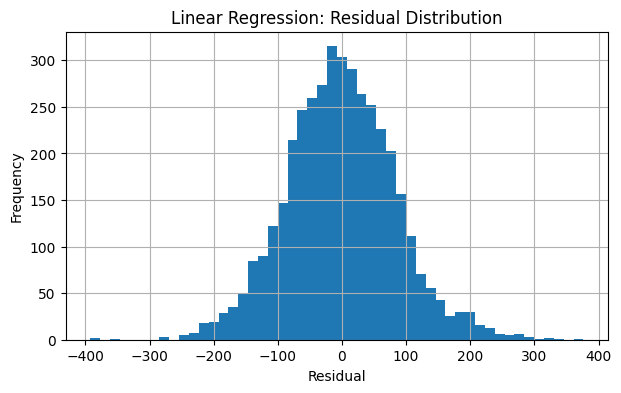

In [14]:
lr_pd["residual"] = lr_pd["mean_traffic"] - lr_pd["prediction"]

plt.figure(figsize=(7, 4))
plt.hist(lr_pd["residual"], bins=50)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Linear Regression: Residual Distribution")
plt.grid(True)
plt.show()


In [26]:
"""Dimensionality Reduction: PCA Training"""

pca = PCA(
    k=3,
    inputCol="features",
    outputCol="pca_features"
)

pca_model = pca.fit(ml_ready_df)
print(f"Explained Variance: {pca_model.explainedVariance.toArray()}")

Explained Variance: [0.2742613  0.12427251 0.11816626]


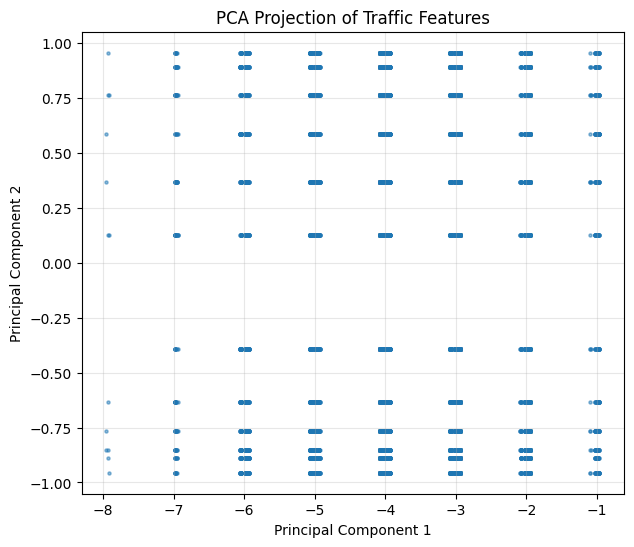

,PC1,PC2,PC3
hour_sin,-1.394036e-16,1.258107e-01,-9.914449e-01
hour_cos,-1.000476e-16,9.556273e-01,1.305262e-01
is_weekend,-1.993384e-15,0.000000e+00,0.000000e+00
is_rush,-1.221245e-15,-2.663608e-01,1.071669e-15
Lanes,-9.916595e-01,3.235194e-16,1.318667e-16


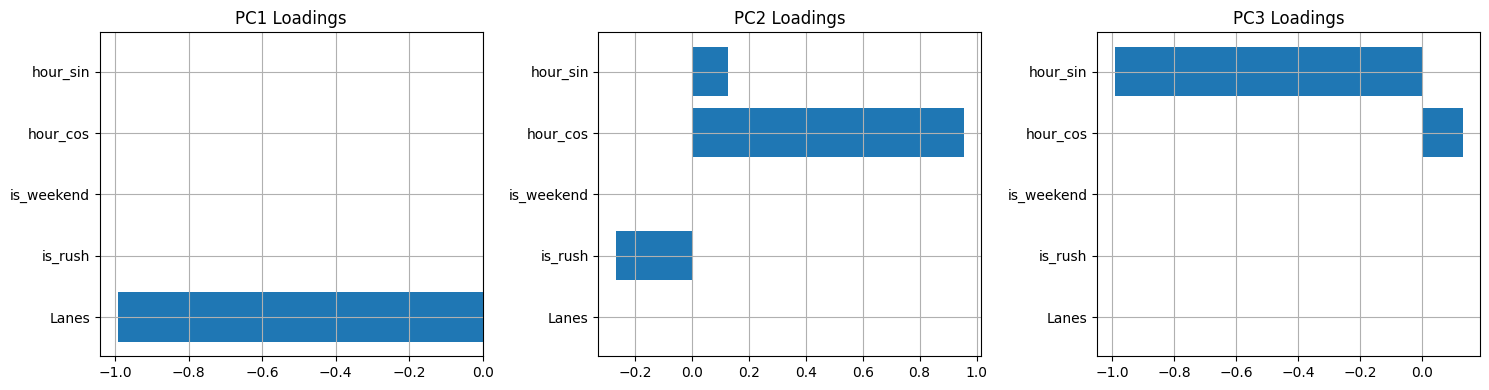

In [30]:
"""PCA: 2D Projection Visualization and Component Interpretation"""

pca_pd = (
    pca_model
    .transform(ml_ready_df)
    .select("pca_features")
    .sample(fraction=0.1, seed=42)
    .rdd
    .map(lambda r: r[0].toArray().tolist())
    .toDF(["PC1", "PC2", "PC3"])
    .toPandas()
)

plt.figure(figsize=(7, 6))
plt.scatter(pca_pd["PC1"], pca_pd["PC2"], s=5, alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Traffic Features")
plt.grid(True, alpha=0.3)
plt.show()

pca_components = pca_model.pc.toArray()

numeric_feature_names = [
    "hour_sin",
    "hour_cos",
    "is_weekend",
    "is_rush",
    "Lanes"
]

pca_loadings_pd = pd.DataFrame(
    pca_components[:len(numeric_feature_names), :3],
    index=numeric_feature_names,
    columns=["PC1", "PC2", "PC3"]
)

display(pca_loadings_pd)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, pc in enumerate(["PC1", "PC2", "PC3"]):
    axes[i].barh(pca_loadings_pd.index, pca_loadings_pd[pc])
    axes[i].set_title(f"{pc} Loadings")
    axes[i].invert_yaxis()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


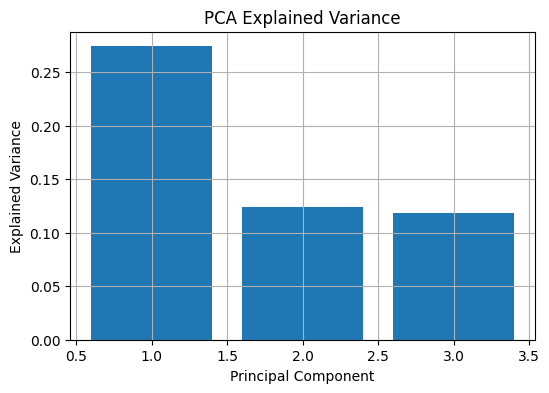

In [31]:
explained_var = pca_model.explainedVariance.toArray()

plt.figure(figsize=(6, 4))
plt.bar(range(1, len(explained_var) + 1), explained_var)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()


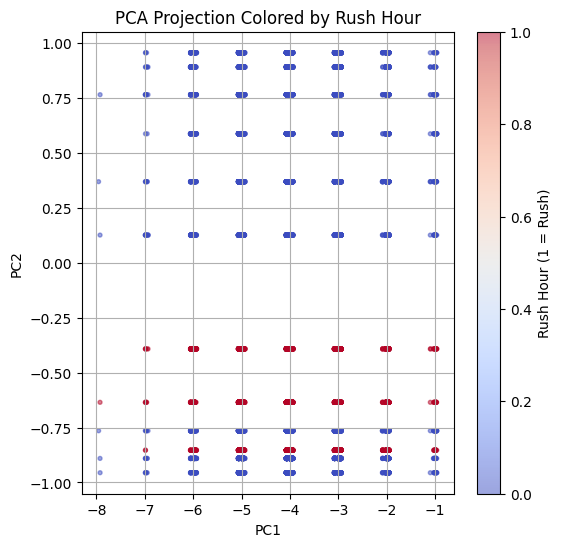

In [33]:
pca_labeled_pd = (
    pca_model
    .transform(ml_ready_df)
    .select("pca_features", "is_rush")
    .sample(fraction=0.05, seed=42)
    .rdd
    .map(lambda r: (
        float(r[0][0]),
        float(r[0][1]),
        int(r[1])
    ))
    .toDF(["PC1", "PC2", "is_rush"])
    .toPandas()
)

plt.figure(figsize=(6, 6))
plt.scatter(
    pca_labeled_pd["PC1"],
    pca_labeled_pd["PC2"],
    c=pca_labeled_pd["is_rush"],
    cmap="coolwarm",
    s=8,
    alpha=0.5
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection Colored by Rush Hour")
plt.colorbar(label="Rush Hour (1 = Rush)")
plt.grid(True)
plt.show()


In [34]:
LABEL_COL = "mean_traffic"

evaluator = RegressionEvaluator(
    labelCol=LABEL_COL,
    predictionCol="prediction",
    metricName="rmse"
)

models = {
    "Decision Tree": DecisionTreeRegressor(
        featuresCol="features",
        labelCol=LABEL_COL,
        maxDepth=8
    ),
    "Random Forest": RandomForestRegressor(
        featuresCol="features",
        labelCol=LABEL_COL,
        numTrees=50,
        maxDepth=10,
        seed=42
    ),
    "Gradient Boosted Trees": GBTRegressor(
        featuresCol="features",
        labelCol=LABEL_COL,
        maxIter=30,
        maxDepth=6,
        seed=42
    )
}

results = []
trained_models = {}

for name, model in models.items():
    fitted = model.fit(train_df)
    preds = fitted.transform(test_df)
    rmse = evaluator.evaluate(preds)
    results.append((name, float(rmse)))
    trained_models[name] = fitted

spark.createDataFrame(
    results, ["model", "rmse"]
).orderBy("rmse").show()

26/01/14 17:19:30 WARN DAGScheduler: Broadcasting large task binary with size 1240.4 KiB
26/01/14 17:19:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
26/01/14 17:19:38 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
26/01/14 17:19:44 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
26/01/14 17:19:50 WARN DAGScheduler: Broadcasting large task binary with size 1516.3 KiB
                                                                                

+--------------------+-----------------+
|               model|             rmse|
+--------------------+-----------------+
|Gradient Boosted ...|66.36100124842892|
|       Random Forest|68.37046129882317|
|       Decision Tree|70.88617554462945|
+--------------------+-----------------+



In [36]:
rf_model = trained_models["Random Forest"]
importances = rf_model.featureImportances.toArray()

rf_importance_df = spark.createDataFrame(
    [(f, float(i)) for f, i in zip(feature_names, importances[:len(feature_names)])],
    ["feature", "importance"]
).orderBy("importance", ascending=False)

rf_importance_df.show()


+----------+--------------------+
|   feature|          importance|
+----------+--------------------+
|  hour_cos|  0.4079478932460514|
|     Lanes| 0.32936789260575855|
|  hour_sin| 0.10726694267516919|
|is_weekend|0.031318795721482655|
|   is_rush| 0.02712748997031724|
+----------+--------------------+



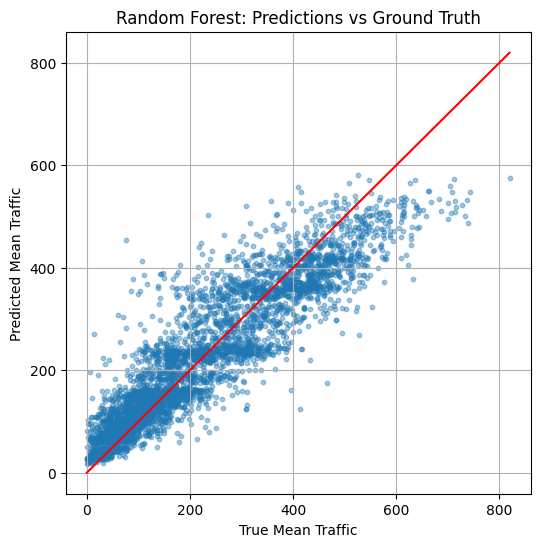

In [38]:
rf_pd = (
    rf_model
    .transform(test_df)
    .select("mean_traffic", "prediction")
    .sample(fraction=0.05, seed=42)
    .toPandas()
)

plt.figure(figsize=(6, 6))
plt.scatter(rf_pd["mean_traffic"], rf_pd["prediction"], alpha=0.4, s=10)
plt.plot(
    [rf_pd["mean_traffic"].min(), rf_pd["mean_traffic"].max()],
    [rf_pd["mean_traffic"].min(), rf_pd["mean_traffic"].max()],
    color="red"
)
plt.xlabel("True Mean Traffic")
plt.ylabel("Predicted Mean Traffic")
plt.title("Random Forest: Predictions vs Ground Truth")
plt.grid(True)
plt.show()


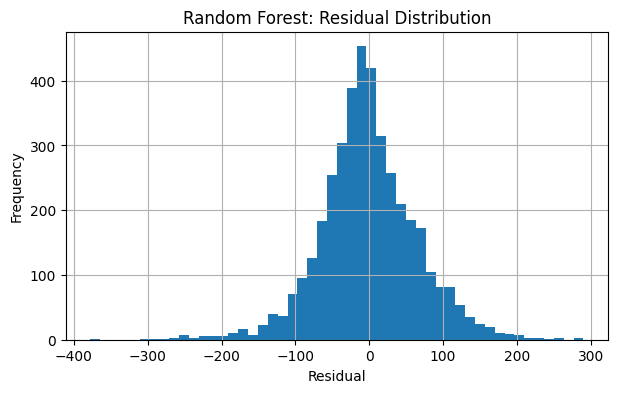

In [39]:
rf_pd["residual"] = rf_pd["mean_traffic"] - rf_pd["prediction"]

plt.figure(figsize=(7, 4))
plt.hist(rf_pd["residual"], bins=50)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Random Forest: Residual Distribution")
plt.grid(True)
plt.show()


In [41]:
"""Cleaning"""

spark.stop()